In [189]:
import os
import json
import pandas as pd

base_dir = "../data/outputs/20251024_1850"

# Read elites
with open(os.path.join(base_dir, "elites.json"), "r") as f:
    elites = json.load(f)
df_elites = pd.DataFrame(elites)

# Read non-elites, if present (assuming file is named 'non_elites.json' or similar, fallback to empty DataFrame)
non_elites_path = os.path.join(base_dir, "non_elites.json")
if os.path.exists(non_elites_path):
    with open(non_elites_path, "r") as f:
        non_elites = json.load(f)
    df_non_elites = pd.DataFrame(non_elites)
else:
    df_non_elites = pd.DataFrame()

# Read EvolutionTracker
with open(os.path.join(base_dir, "EvolutionTracker.json"), "r") as f:
    evolution_tracker = json.load(f)
df_generations = pd.DataFrame(evolution_tracker.get("generations", []))

# Now you have df_elites, df_non_elites, and df_generations as DataFrames to work with.


In [190]:
df_generations.head()

,generation_number,genome_id,max_score_variants,avg_fitness,parents,top_10,variants_created,mutation_variants,crossover_variants,elites_threshold,operator_statistics,elites_count,removal_threshold,avg_fitness_elites,avg_fitness_non_elites,avg_fitness_generation,min_score_variants,avg_fitness_variants
0,0,66,0.2546,0.0357,None,None,NaN,NaN,NaN,0.1782,{},2,0.0076,0.2200,0.0319,0.0357,0.0001,0.0001
1,1,113,0.3610,0.0465,"[91, 19]","[66, 91, 46, 35, 28, 53, 61, 93, 80, 56]",16.0,16.0,0.0,0.2527,{'SemanticFusionCrossover': {'duplicates_remov...,4,0.0108,0.3051,0.0383,0.0479,0.0115,0.1134
2,2,113,0.1599,0.0515,"[111, 53]","[113, 111, 109, 66, 102, 91, 46, 35, 107, 117]",11.0,11.0,0.0,0.2527,{'SemanticFusionCrossover': {'duplicates_remov...,4,0.0108,0.3051,0.0430,0.0515,0.0214,0.0886
3,3,113,0.1836,0.0554,"[113, 4]","[113, 111, 109, 66, 102, 91, 127, 123, 46, 35]",14.0,14.0,0.0,0.2527,{'SemanticFusionCrossover': {'duplicates_remov...,4,0.0108,0.3051,0.0479,0.0554,0.0191,0.0891
4,4,113,0.2546,0.0600,"[113, 67]","[113, 111, 109, 66, 102, 91, 136, 133, 127, 123]",11.0,11.0,0.0,0.2527,{'SemanticFusionCrossover': {'duplicates_remov...,5,0.0108,0.2950,0.0517,0.0600,0.0331,0.1168


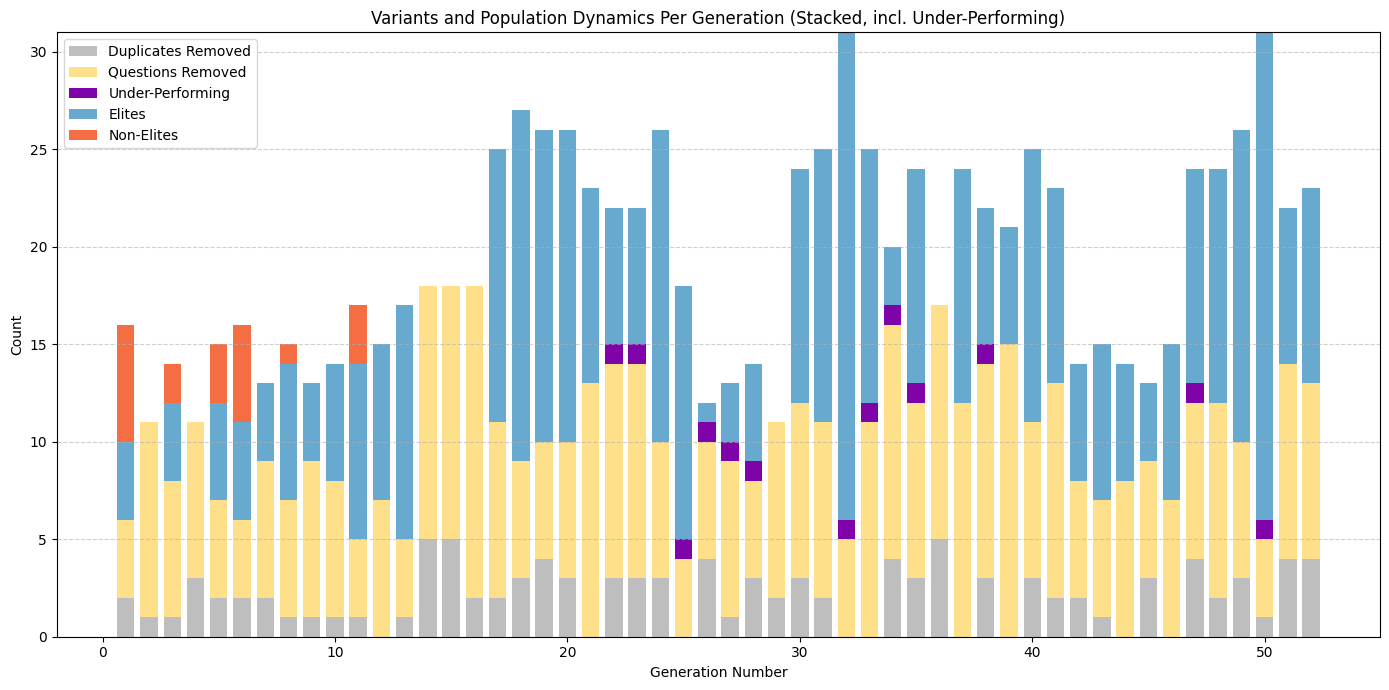

In [191]:
import matplotlib.pyplot as plt

# Safely extract values from DataFrame columns
def safe_list_from_column(df, col):
    return [gen.get(col, None) for gen in df.to_dict(orient='records')]

gen_numbers = safe_list_from_column(df_generations, "generation_number")
variants_created = safe_list_from_column(df_generations, "variants_created")
elites_count = safe_list_from_column(df_generations, "elites_count") if "elites_count" in df_generations.columns else [None]*len(df_generations)

# Extract total questions_removed and duplicates from operator_statistics
def sum_operator_stat(gs, stat_key):
    out = []
    for g in gs.to_dict(orient='records'):
        opstats = g.get("operator_statistics", {})
        if not opstats or not isinstance(opstats, dict):
            out.append(0)
            continue
        total = 0
        for op, stat_dict in opstats.items():
            if isinstance(stat_dict, dict) and stat_key in stat_dict:
                v = stat_dict.get(stat_key)
                if isinstance(v, int):
                    total += v
        out.append(total)
    return out

questions_removed = sum_operator_stat(df_generations, "question_mark_rejections")
duplicates = sum_operator_stat(df_generations, "duplicates_removed")

# Determine removal_threshold per generation (or fallback to zero/None if missing)
removal_threshold_col = "removal_threshold"
if removal_threshold_col in df_generations.columns:
    removal_thresholds = safe_list_from_column(df_generations, removal_threshold_col)
else:
    removal_thresholds = [None] * len(df_generations)

# Estimate elites, non-elites, AND UNDER-PERFORMING (below removal threshold)
non_elites_count = []
under_performing_count = []
for i, (vc, ec, thresh) in enumerate(zip(variants_created, elites_count, removal_thresholds)):
    if vc is None or ec is None or thresh is None:
        non_elites_count.append(None)
        under_performing_count.append(None)
        continue

    # BEST EFFORT: If have 'min_score_variants', estimate at least 1 as under-performing if min <= threshold; else 0
    if "min_score_variants" in df_generations.columns:
        min_score = df_generations.iloc[i].get("min_score_variants", None)
        if min_score is not None and min_score <= thresh:
            under_performing_count.append(1)
        else:
            under_performing_count.append(0)
    else:
        under_performing_count.append(0)

    if vc is not None and ec is not None:
        non_elites_count.append(vc - ec)
    else:
        non_elites_count.append(None)

import numpy as np

bar_width = 0.75

var_created = np.array([v if v is not None else 0 for v in variants_created])
elites = np.array([e if e is not None else 0 for e in elites_count])
non_elites = np.array([ne if ne is not None else 0 for ne in non_elites_count])
under_performing = np.array([up if up is not None else 0 for up in under_performing_count])
questions = np.array([q if q is not None else 0 for q in questions_removed])
dups = np.array([d if d is not None else 0 for d in duplicates])

# Align bar segments: stack (bottom up: dups -> questions -> under-performing -> elites -> non-elites)
dups_shown = np.minimum(var_created, dups)
questions_shown = np.minimum(var_created - dups_shown, questions)
under_performing_shown = np.minimum(var_created - dups_shown - questions_shown, under_performing)
elites_shown = np.minimum(var_created - dups_shown - questions_shown - under_performing_shown, elites)
non_elites_shown = np.maximum(var_created - dups_shown - questions_shown - under_performing_shown - elites_shown, 0)

plt.figure(figsize=(14, 7))

p1 = plt.bar(gen_numbers, dups_shown, 
             width=bar_width, color="#bebebe", label="Duplicates Removed", bottom=0)
p2 = plt.bar(gen_numbers, questions_shown, 
             width=bar_width, color="#fee08b", label="Questions Removed", bottom=dups_shown)
p3 = plt.bar(gen_numbers, under_performing_shown, 
             width=bar_width, color="#7e03a8", label="Under-Performing", bottom=dups_shown+questions_shown)  # purple
p4 = plt.bar(gen_numbers, elites_shown, 
             width=bar_width, color="#67a9cf", label="Elites", 
             bottom=dups_shown+questions_shown+under_performing_shown)
p5 = plt.bar(gen_numbers, non_elites_shown, 
             width=bar_width, color="#f46d43", label="Non-Elites", 
             bottom=dups_shown+questions_shown+under_performing_shown+elites_shown)

plt.xlabel("Generation Number")
plt.ylabel("Count")
plt.title("Variants and Population Dynamics Per Generation (Stacked, incl. Under-Performing)")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


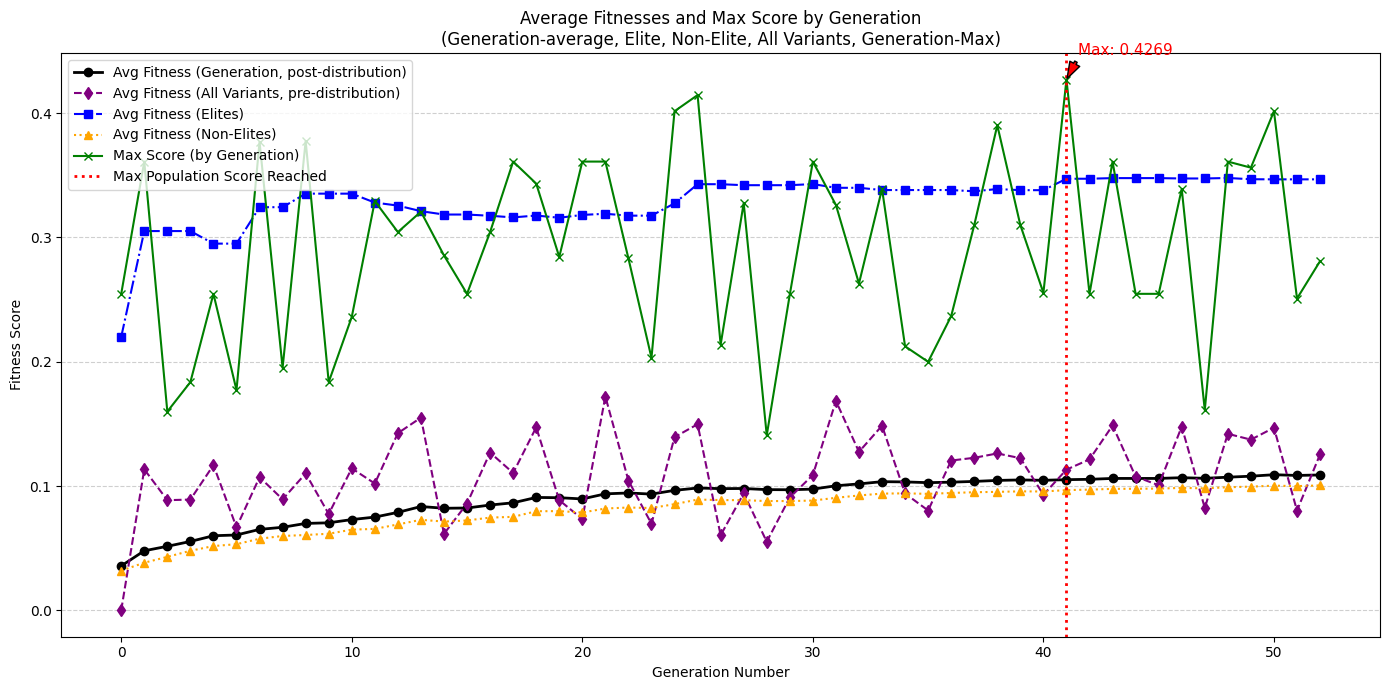

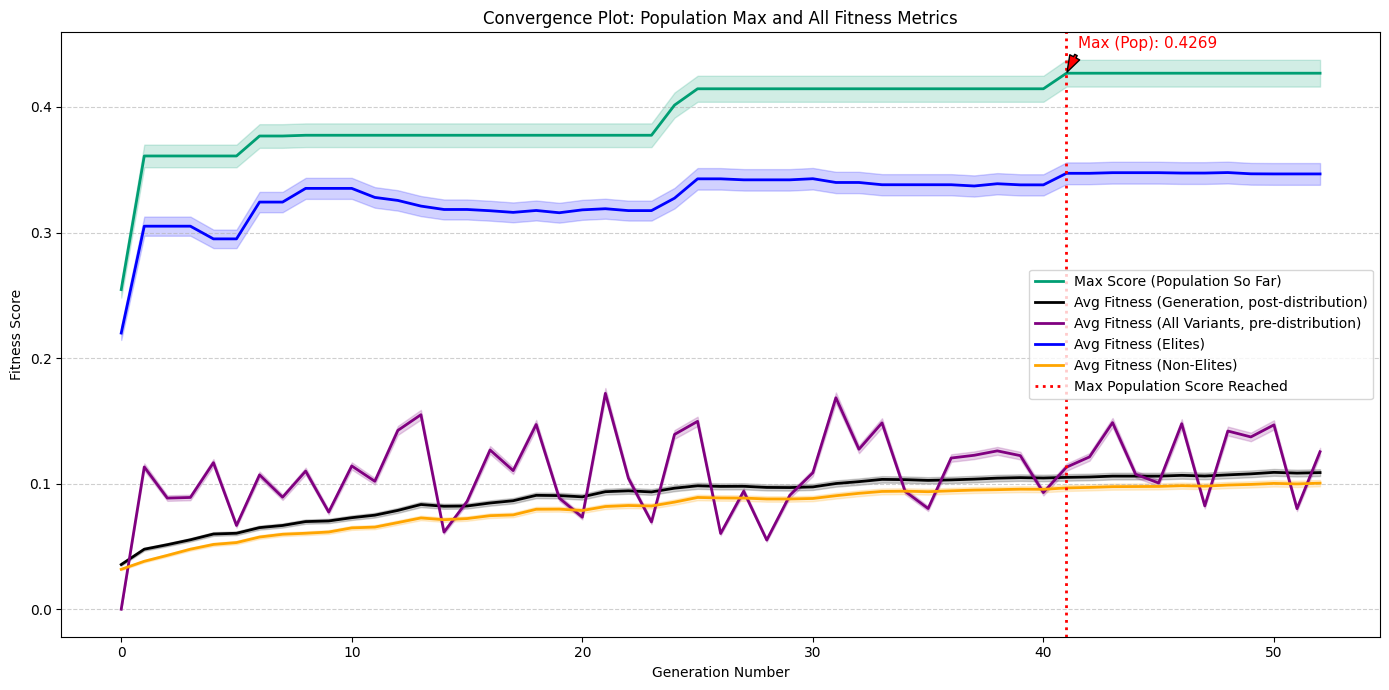

In [192]:
# Visualization 1:
# Show all the following curves by generation (from df_generations):
# - avg_fitness_generation (average fitness for the whole selected generation, post-distribution: all elites and non-elites)
# - avg_fitness_variants (average fitness of all variants generated prior to post-selection for a given generation)
# - avg_fitness_elites (average fitness of just the elites)
# - avg_fitness_non_elites (average fitness of the non-elites)
# - max_score_variants (highest fitness among the variants *in* the given generation)
# Add a vertical dotted line at the generation where the population max is first reached.

import matplotlib.pyplot as plt

x = df_generations['generation_number']
y_gen = df_generations['avg_fitness_generation']
y_var = df_generations['avg_fitness_variants']
y_elites = df_generations['avg_fitness_elites']
y_none = df_generations['avg_fitness_non_elites']
y_max = df_generations['max_score_variants']

max_score_overall = y_max.max()
gen_of_max = x[y_max == max_score_overall].iloc[0]

plt.figure(figsize=(14,7))
plt.plot(x, y_gen, label='Avg Fitness (Generation, post-distribution)', color='black', linewidth=2, marker='o')
plt.plot(x, y_var, label='Avg Fitness (All Variants, pre-distribution)', color='purple', linestyle='--', marker='d')
plt.plot(x, y_elites, label='Avg Fitness (Elites)', color='blue', linestyle='-.', marker='s')
plt.plot(x, y_none, label='Avg Fitness (Non-Elites)', color='orange', linestyle=':', marker='^')
plt.plot(x, y_max, label='Max Score (by Generation)', color='green', linestyle='-', marker='x')
plt.axvline(x=gen_of_max, color='red', linestyle=':', linewidth=2, label='Max Population Score Reached')
plt.annotate(f"Max: {max_score_overall:.4f}",
             xy=(gen_of_max, max_score_overall),
             xytext=(gen_of_max+0.5, max_score_overall+0.02),
             arrowprops=dict(facecolor='red', shrink=0.05, width=2, headwidth=8),
             fontsize=11,
             color='red')
plt.xlabel("Generation Number")
plt.ylabel("Fitness Score")
plt.title("Average Fitnesses and Max Score by Generation\n(Generation-average, Elite, Non-Elite, All Variants, Generation-Max)")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


# Visualization 2:
# A "convergence" plot as in the screenshot, but for all curves above.
# For max score: show the *population max so far* up to each generation.
# For all five metrics: show main curve, with ±2.5% shaded bands as visual "uncertainty".
# All lines correspond exactly to the same metrics/definitions as in Visualization 1.
# Vertical line marks where the population max is first reached.

import numpy as np

y_max_population = np.maximum.accumulate(y_max.values)
y_var_arr = np.array(y_var)
y_elites_arr = np.array(y_elites)
y_none_arr = np.array(y_none)
y_gen_arr = np.array(y_gen)
x_arr = np.array(x)

def plot_shaded_curve(x, y, color, label, alpha_band=0.18):
    plt.plot(x, y, color=color, label=label, lw=2)
    variance = np.abs(0.025 * y)
    lower = y - variance
    upper = y + variance
    plt.fill_between(x, lower, upper, color=color, alpha=alpha_band)

plt.figure(figsize=(14,7))
plot_shaded_curve(x_arr, y_max_population, color='#009E73', label='Max Score (Population So Far)')
plot_shaded_curve(x_arr, y_gen_arr, color='black', label='Avg Fitness (Generation, post-distribution)')
plot_shaded_curve(x_arr, y_var_arr, color='purple', label='Avg Fitness (All Variants, pre-distribution)')
plot_shaded_curve(x_arr, y_elites_arr, color='blue', label='Avg Fitness (Elites)')
plot_shaded_curve(x_arr, y_none_arr, color='orange', label='Avg Fitness (Non-Elites)')

plt.axvline(x=gen_of_max, color='red', linestyle=':', linewidth=2, label='Max Population Score Reached')
plt.annotate(f"Max (Pop): {max_score_overall:.4f}",
             xy=(gen_of_max, max_score_overall),
             xytext=(gen_of_max+0.5, max_score_overall+0.02),
             arrowprops=dict(facecolor='red', shrink=0.05, width=2, headwidth=8),
             fontsize=11,
             color='red')

plt.xlabel("Generation Number")
plt.ylabel("Fitness Score")
plt.title("Convergence Plot: Population Max and All Fitness Metrics")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [44]:
# Combine elites and non-elites and count genomes by operators

# For each generation, combine elite and non-elite genome_ids, and count by operator
from collections import Counter, defaultdict

# We'll use the (already loaded) df_generations in the notebook, or load if not present
generations = df_generations_ie1_150 if 'df_generations_ie1_150' in locals() else df_generations_ie1

operator_counts_by_generation = []

for idx, row in generations.iterrows():
    # Gather all genome IDs (elites and non-elites), guarding against missing/non-list data
    elite_genomes = row.get('elites', []) or []
    nonelite_genomes = row.get('non_elites', []) or []
    if isinstance(elite_genomes, str):
        try:
            elite_genomes = eval(elite_genomes)
        except Exception:
            elite_genomes = []
    if isinstance(nonelite_genomes, str):
        try:
            nonelite_genomes = eval(nonelite_genomes)
        except Exception:
            nonelite_genomes = []

    all_genome_ids = set(elite_genomes) | set(nonelite_genomes)

    # Map genome_id to operator by scanning the variants in the full EvolutionTracker
    operator_counter = Counter()
    # For this, need to find which operator created each genome
    # The main EvolutionTracker is loaded as et_ie1
    genomeid_to_operator = {}
    # The data is generally a list of generations, each with a list of variants and their operator
    # We'll prepare a mapping once for all (for efficiency), if not already present
    if 'genomeid_to_operator_master' not in globals():
        genomeid_to_operator_master = {}
        for g in et_ie1['generations']:
            for k in ['elites', 'non_elites', 'variants']:
                items = g.get(k, [])
                if isinstance(items, dict):  # Sometimes comes as dict
                    items = list(items.values())
                for v in items:
                    if isinstance(v, dict):
                        genome_id = str(v.get('id', v.get('genome_id', '')))
                        op = v.get('operator', None)
                        if genome_id and op:
                            genomeid_to_operator_master[genome_id] = op
                    # If it's a string, skip for now
        # As a fallback, look into 'variants_data' if available (some EvolutionTracker formats)

    # Now, for all genome_ids in this generation, get their operator
    for gid in all_genome_ids:
        gid_str = str(gid)
        op = genomeid_to_operator_master.get(gid_str, None)
        if op is not None:
            operator_counter[op] += 1
        else:
            operator_counter["Unknown"] += 1

    operator_counts_by_generation.append({
        "generation_number": row['generation_number'],
        "operator_counts": dict(operator_counter)
    })

# Example: print counts for last generation available
print("Operator counts for last generation:")
print(operator_counts_by_generation[-1])

# If you want a DataFrame for plotting:
df_op_counts = pd.DataFrame([
    {
        "generation_number": x['generation_number'],
        **x['operator_counts']
    }
    for x in operator_counts_by_generation
])

# And preview, e.g. the first few lines
print(df_op_counts.head())



NameError: name 'df_generations_ie1' is not defined

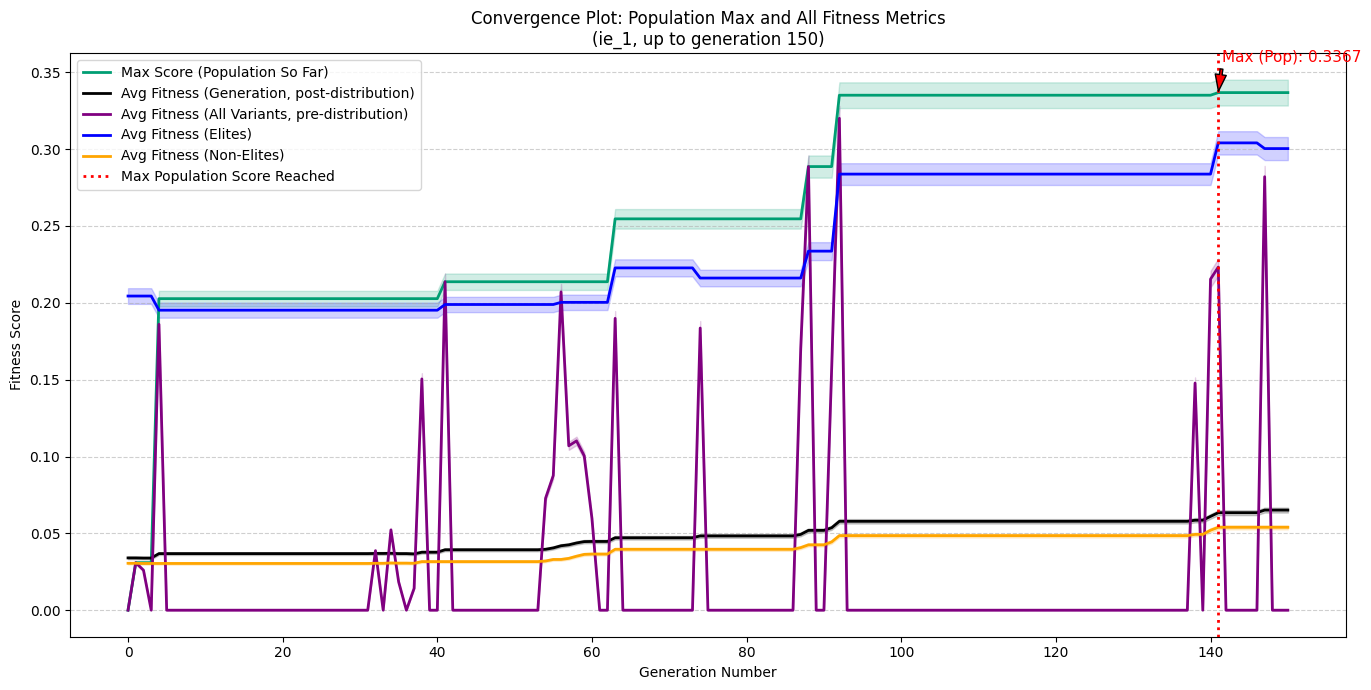

In [32]:
import json
import pandas as pd
import numpy as np

# Load the EvolutionTracker for ../data/archive/ie_1
with open('../data/archive/ie_1/EvolutionTracker.json', 'r') as f:
    et_ie1 = json.load(f)

# Extract the generations data and turn into a DataFrame
generations_ie1 = et_ie1['generations']
df_generations_ie1 = pd.DataFrame(generations_ie1)

# Filter to only include generations up to and including 150
df_generations_ie1_150 = df_generations_ie1[df_generations_ie1['generation_number'] <= 150]

# Prepare variables for plotting using the filtered DataFrame
x_ie1 = df_generations_ie1_150['generation_number']
y_gen_ie1 = df_generations_ie1_150['avg_fitness_generation']
y_var_ie1 = df_generations_ie1_150['avg_fitness_variants']
y_elites_ie1 = df_generations_ie1_150['avg_fitness_elites']
y_none_ie1 = df_generations_ie1_150['avg_fitness_non_elites']
y_max_ie1 = df_generations_ie1_150['max_score_variants']

# Calculate the max score "so far" for each generation (convergence curve)
y_max_population_ie1 = np.maximum.accumulate(y_max_ie1.values)
x_ie1_arr = np.array(x_ie1)
y_var_arr_ie1 = np.array(y_var_ie1)
y_elites_arr_ie1 = np.array(y_elites_ie1)
y_none_arr_ie1 = np.array(y_none_ie1)
y_gen_arr_ie1 = np.array(y_gen_ie1)

# Find overall max and the generation at which it is first reached
max_score_overall_ie1 = y_max_population_ie1.max()
gen_of_max_ie1 = x_ie1_arr[y_max_population_ie1 == max_score_overall_ie1][0] if (y_max_population_ie1 == max_score_overall_ie1).any() else None

def plot_shaded_curve(x, y, color, label, alpha_band=0.18):
    plt.plot(x, y, color=color, label=label, lw=2)
    variance = np.abs(0.025 * y)
    lower = y - variance
    upper = y + variance
    plt.fill_between(x, lower, upper, color=color, alpha=alpha_band)

plt.figure(figsize=(14,7))
plot_shaded_curve(x_ie1_arr, y_max_population_ie1, color='#009E73', label='Max Score (Population So Far)')
plot_shaded_curve(x_ie1_arr, y_gen_arr_ie1, color='black', label='Avg Fitness (Generation, post-distribution)')
plot_shaded_curve(x_ie1_arr, y_var_arr_ie1, color='purple', label='Avg Fitness (All Variants, pre-distribution)')
plot_shaded_curve(x_ie1_arr, y_elites_arr_ie1, color='blue', label='Avg Fitness (Elites)')
plot_shaded_curve(x_ie1_arr, y_none_arr_ie1, color='orange', label='Avg Fitness (Non-Elites)')

if gen_of_max_ie1 is not None:
    plt.axvline(x=gen_of_max_ie1, color='red', linestyle=':', linewidth=2, label='Max Population Score Reached')
    plt.annotate(f"Max (Pop): {max_score_overall_ie1:.4f}",
                 xy=(gen_of_max_ie1, max_score_overall_ie1),
                 xytext=(gen_of_max_ie1+0.5, max_score_overall_ie1+0.02),
                 arrowprops=dict(facecolor='red', shrink=0.05, width=2, headwidth=8),
                 fontsize=11,
                 color='red')

plt.xlabel("Generation Number")
plt.ylabel("Fitness Score")
plt.title("Convergence Plot: Population Max and All Fitness Metrics\n(ie_1, up to generation 150)")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
